# FSRS vs SM16 vs SM17

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs-vs-sm17/blob/main/FSRS-v-SM16-v-SM17.ipynb)

To run this comparison, you need upload `SM16-v-SM17.csv` file to the same folder as this notebook.

You can find `SM16-v-SM17.csv` in `sm18/systems/{collection_name}/stats` folder. The private content is stored in column `Title`. I recommend removing it before uploading to colab and sharing. Don't forget to make a copy before you delete it.

If you would like to support this project, please consider sharing your data with us. The shared data will be stored in [./dataset/](./dataset/) folder. 

You can open an issue to submit it: https://github.com/open-spaced-repetition/fsrs-vs-sm17/issues/new/choose

In [1]:
import pandas as pd
from datetime import datetime

try:
    df = pd.read_csv(f"./SM16-v-SM17.csv", encoding="utf-8")
except:
    df = pd.read_csv(f"./SM16-v-SM17.csv", encoding="gbk")
df.columns = df.columns.str.strip()


def convert_to_datetime(date_str):
    try:
        return datetime.strptime(date_str, '%b %d %Y %H:%M:%S')
    except ValueError:
        try:
            return datetime.strptime(date_str, '%m月 %d %Y %H:%M:%S')
        except ValueError as e:
            print(e)
            return pd.NaT


df['Date'] = df['Date'].apply(convert_to_datetime)
df.dropna(subset=['Date'], inplace=True)

In [2]:
from itertools import accumulate

dataset = df[['Date', 'Element No', 'Used interval',
              'R (SM16)', 'R (SM17)', 'R (SM17)(exp)', 'Grade', 'Success']].sort_values(by=['Element No', 'Date'])
dataset.rename(columns={'Element No': 'card_id',
                        'Date': 'review_date',
                        'Used interval': 'delta_t',
                        'R (SM17)(exp)': 'R (SM17(exp))',
                        'Success': 'y'}, inplace=True)
dataset['i'] = dataset.groupby('card_id').cumcount() + 1
dataset['review_rating'] = dataset['Grade'].map(
    {0: 1, 1: 1, 2: 1, 3: 2, 4: 3, 5: 4})


def cum_concat(x):
    return list(accumulate(x))


t_history = dataset.groupby('card_id', group_keys=False)['delta_t'].apply(
    lambda x: cum_concat([[int(i)] for i in x]))
dataset['t_history'] = [','.join(map(str, item[:-1]))
                        for sublist in t_history for item in sublist]
r_history = dataset.groupby('card_id', group_keys=False)[
    'review_rating'].apply(lambda x: cum_concat([[i] for i in x]))
dataset['r_history'] = [','.join(map(str, item[:-1]))
                        for sublist in r_history for item in sublist]
dataset = dataset[(dataset['i'] > 1) & (dataset['delta_t'] > 0) & (
    dataset['t_history'].str.count(',0') == 0)].copy()
print(f"Number of repetitions: {dataset.shape[0]}")
print(f"Number of cards: {dataset['card_id'].nunique()}")

Number of repetitions: 27669
Number of cards: 9821


In [3]:
%pip install -q FSRS-Optimizer==4.12.1

from fsrs_optimizer import lineToTensor, collate_fn, power_forgetting_curve, FSRS, RevlogDataset, WeightClipper
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import torch

tqdm.pandas()


def train(revlogs):
    revlogs = revlogs[(revlogs['i'] > 1) & (revlogs['delta_t'] > 0) & (
        revlogs['t_history'].str.count(',0') == 0)].copy()
    revlogs['tensor'] = revlogs.progress_apply(lambda x: lineToTensor(
        list(zip([x['t_history']], [x['r_history']]))[0]), axis=1)
    revlogs.sort_values(by=['review_date'], inplace=True)
    revlogs.reset_index(drop=True, inplace=True)

    model = FSRS([0.4, 0.6, 2.4, 5.8, 4.93, 0.94, 0.86, 0.01,
                 1.49, 0.14, 0.94, 2.18, 0.05, 0.34, 1.26, 0.29, 2.61])
    optimizer = torch.optim.Adam(model.parameters(), lr=8e-3)
    loss_fn = torch.nn.BCELoss(reduction='none')
    enable_experience_replay = True
    replay_steps = 32

    dataset = RevlogDataset(revlogs)
    dataloader = DataLoader(dataset, shuffle=False, collate_fn=collate_fn)
    clipper = WeightClipper()
    d = []
    s = []
    r = []

    for i, sample in enumerate(tqdm(dataloader)):
        model.train()
        optimizer.zero_grad()
        sequence, delta_t, label, seq_len = sample
        output, _ = model(sequence)
        stability, difficulty = output[seq_len-1, 0].transpose(0, 1)
        d.append(difficulty.detach().numpy()[0])
        s.append(stability.detach().numpy()[0])
        retention = power_forgetting_curve(delta_t, stability)
        r.append(retention.detach().numpy()[0])
        loss = loss_fn(retention, label).sum()
        loss.backward()
        optimizer.step()
        model.apply(clipper)

        if enable_experience_replay and (i + 1) % replay_steps == 0:
            # experience replay
            replay_dataset = RevlogDataset(revlogs[:i+1])  # avoid data leakage
            replay_generator = torch.Generator().manual_seed(42+i)
            replay_dataloader = DataLoader(replay_dataset, batch_size=(
                i + 1)//32, shuffle=True, collate_fn=collate_fn, generator=replay_generator)
            for j, batch in enumerate(replay_dataloader):
                model.train()
                optimizer.zero_grad()
                sequences, delta_ts, labels, seq_lens = batch
                real_batch_size = seq_lens.shape[0]
                outputs, _ = model(sequences)
                stabilities = outputs[seq_lens-1,
                                      torch.arange(real_batch_size), 0]
                retentions = power_forgetting_curve(delta_ts, stabilities)
                loss = loss_fn(retentions, labels).sum()
                loss.backward()
                optimizer.step()
                model.apply(clipper)

    revlogs['difficulty'] = d
    revlogs['stability'] = s
    revlogs['R (FSRS)'] = r

    return revlogs

revlogs = train(dataset)

Note: you may need to restart the kernel to use updated packages.


  0%|          | 0/27669 [00:00<?, ?it/s]

  0%|          | 0/27669 [00:00<?, ?it/s]

In [4]:
from sklearn.metrics import mean_squared_error, log_loss


print("SM16 RMSE: ", mean_squared_error(
    revlogs["y"], revlogs["R (SM16)"], squared=False))
print("SM17 RMSE: ", mean_squared_error(
    revlogs["y"], revlogs["R (SM17)"], squared=False))
print("SM17(exp) RMSE: ", mean_squared_error(
    revlogs["y"], revlogs["R (SM17(exp))"], squared=False))
print("FSRS RMSE: ", mean_squared_error(
    revlogs['y'], revlogs['R (FSRS)'], squared=False))
print()
print("SM16 LogLoss: ", log_loss(revlogs["y"], revlogs["R (SM16)"]))
print("SM17 LogLoss: ", log_loss(revlogs["y"], revlogs["R (SM17)"]))
print("SM17(exp) LogLoss: ", log_loss(revlogs["y"], revlogs["R (SM17(exp))"]))
print("FSRS LogLoss: ", log_loss(revlogs['y'], revlogs['R (FSRS)']))

SM16 RMSE:  0.35162383858926916
SM17 RMSE:  0.345333679363892
SM17(exp) RMSE:  0.35429926417226754
FSRS RMSE:  0.3310677786781869

SM16 LogLoss:  0.4189341752236384
SM17 LogLoss:  0.47358402731787663
SM17(exp) LogLoss:  0.4890603838401848
FSRS LogLoss:  0.37137918338236064


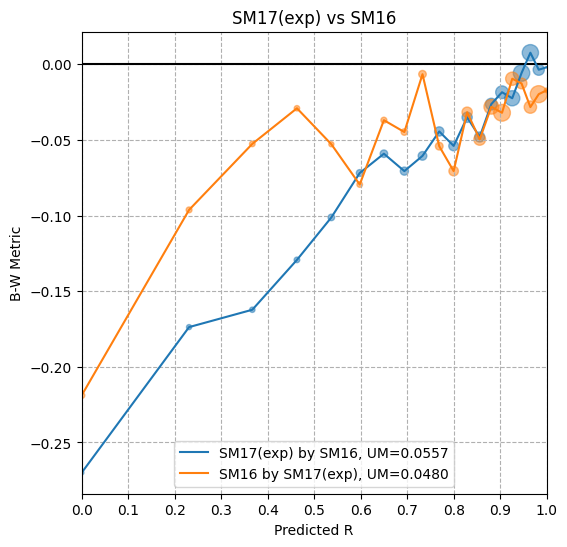

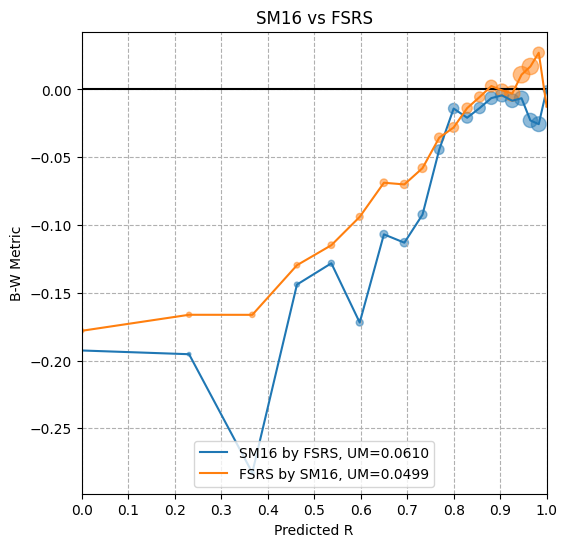

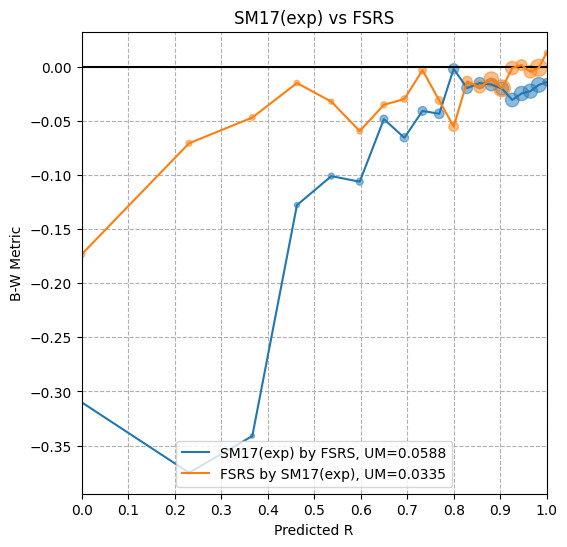

In [5]:
import matplotlib.pyplot as plt
import numpy as np


def cross_comparison(revlogs, algoA, algoB):
    cross_comparison_record = revlogs[[f'R ({algoA})', f'R ({algoB})', 'y']].copy()

    def get_bin(x, bins=20):
        return (np.log(np.exp(np.log(bins) * x).round()) / np.log(bins)).round(3)

    for algo in (algoA, algoB):
        cross_comparison_record[f'{algo}_B-W'] = cross_comparison_record[f'R ({algo})'] - \
            cross_comparison_record['y']
        cross_comparison_record[f'{algo}_bin'] = cross_comparison_record[f'R ({algo})'].map(
            get_bin)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()
    ax.axhline(y=0.0, color='black', linestyle='-')

    for algoA, algoB in [(algoA, algoB), (algoB, algoA)]:
        cross_comparison_group = cross_comparison_record.groupby(by=f'{algoA}_bin').agg(
            {'y': ['mean'], f'{algoB}_B-W': ['mean'], f'R ({algoB})': ['mean', 'count']})
        universal_metric = mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group[
                                              f'R ({algoB})', 'mean'], sample_weight=cross_comparison_group[f'R ({algoB})', 'count'], squared=False)
        cross_comparison_group[f'R ({algoB})', 'percent'] = cross_comparison_group[f'R ({algoB})',
                                                                                   'count'] / cross_comparison_group[f'R ({algoB})', 'count'].sum()
        ax.scatter(cross_comparison_group.index,
                   cross_comparison_group[f'{algoB}_B-W', 'mean'], s=cross_comparison_group[f'R ({algoB})', 'percent'] * 1024, alpha=0.5)
        ax.plot(cross_comparison_group[f'{algoB}_B-W', 'mean'],
                label=f'{algoB} by {algoA}, UM={universal_metric:.4f}')

    ax.legend(loc='lower center')
    ax.grid(linestyle='--')
    ax.set_title(f"{algoA} vs {algoB}")
    ax.set_xlabel('Predicted R')
    ax.set_ylabel('B-W Metric')
    ax.set_xlim(0, 1)
    ax.set_xticks(np.arange(0, 1.1, 0.1))

    fig.show()


cross_comparison(revlogs, 'SM16', 'SM17(exp)')
cross_comparison(revlogs, 'FSRS', 'SM16')
cross_comparison(revlogs, 'FSRS', 'SM17(exp)')